In [1]:
import _cffi_backend
import numpy as np
from datasets import load_dataset
from pixel_datasets.dataset_transformations import SyntheticDatasetTransform
from pixel_datasets.pixel_dataset_generator import PretrainingDataset
from pixel_datasets.utils.utils import plot_arrays
from pixel_datasets.glue_dataset_generator import GlueDatasetForPixel
import wandb


In [16]:
import torch.utils.data.dataloader

In [3]:
rng = np.random.RandomState(2)
transform = SyntheticDatasetTransform(wandb.config, rng=rng)
train_dataset = GlueDatasetForPixel(config=wandb.config, task=wandb.config.task, transform=transform, rng=rng)

In [4]:
train_dataset.image_generator.font_list.head()

,path,hasLower,hasNum,base_size
0,fonts/106beats.ttf,True,True,22.0
1,fonts/3M Trislan.ttf,True,True,22.0
2,fonts/5yearsoldfont.ttf,True,True,22.0
3,fonts/ABeeZee-Italic.ttf,True,True,19.0
4,fonts/ABeeZee-Regular.ttf,True,True,19.0


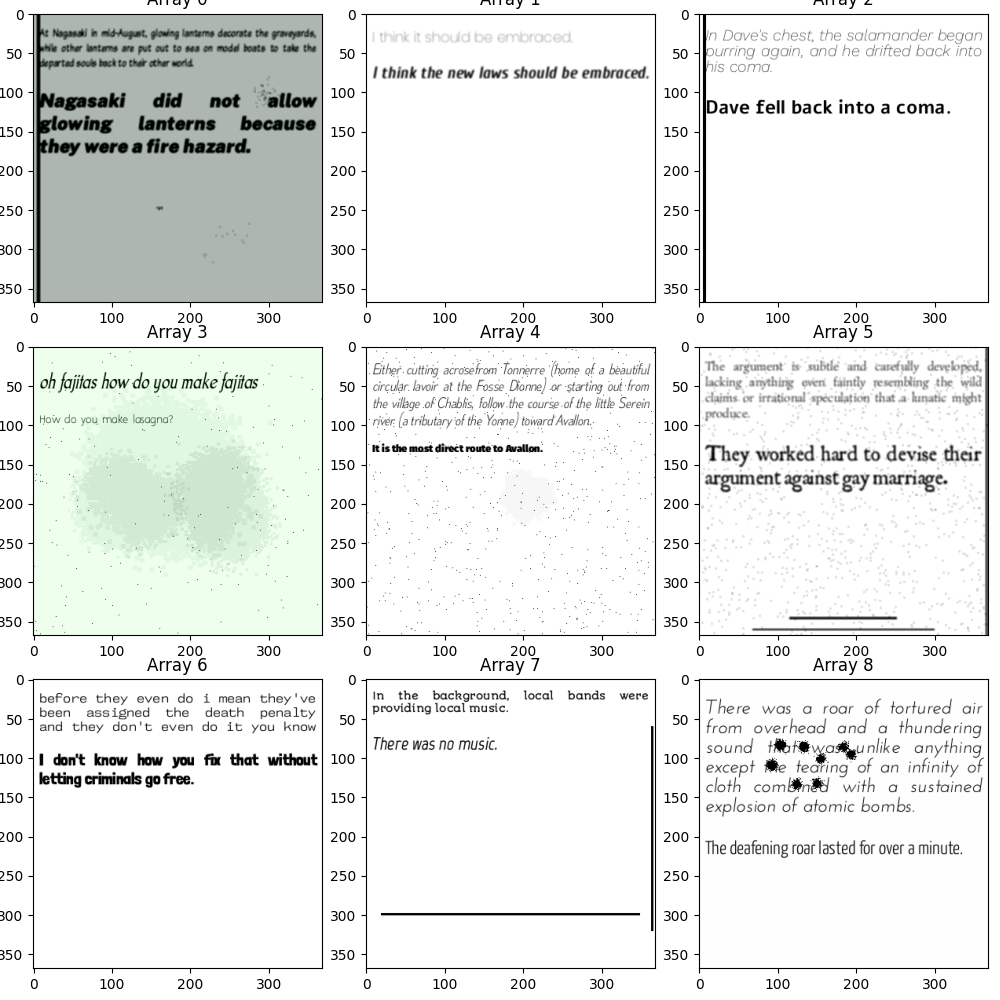

In [5]:
figures = []
for i in range(3):
    counter = 0
    for j in np.random.randint(0, len(train_dataset), 3):
        batch = train_dataset[int(j)]
        im = batch["pixel_values"].numpy().astype("uint8").transpose(1, 2, 0)
        
        figures.append(im)
        counter += 1

im = plot_arrays(figures)
im

In [14]:
wandb.init(config="/home/knf792/PycharmProjects/pixel-2/configs/pretraining_config.yaml", mode="disabled")
rng = np.random.RandomState(2)
transform = SyntheticDatasetTransform(wandb.config, rng=rng)
text_dataset = load_dataset("wikipedia", "20220301.simple")

transform = SyntheticDatasetTransform(wandb.config, rng=rng)
train_dataset = PretrainingDataset(wandb.config, text_dataset["train"], transform, rng=rng)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:randomizing dataset with worker id=0 and epoch=0
INFO:root:randomizing dataset with worker id=0 and epoch=1
INFO:root:randomizing dataset with worker id=0 and epoch=2


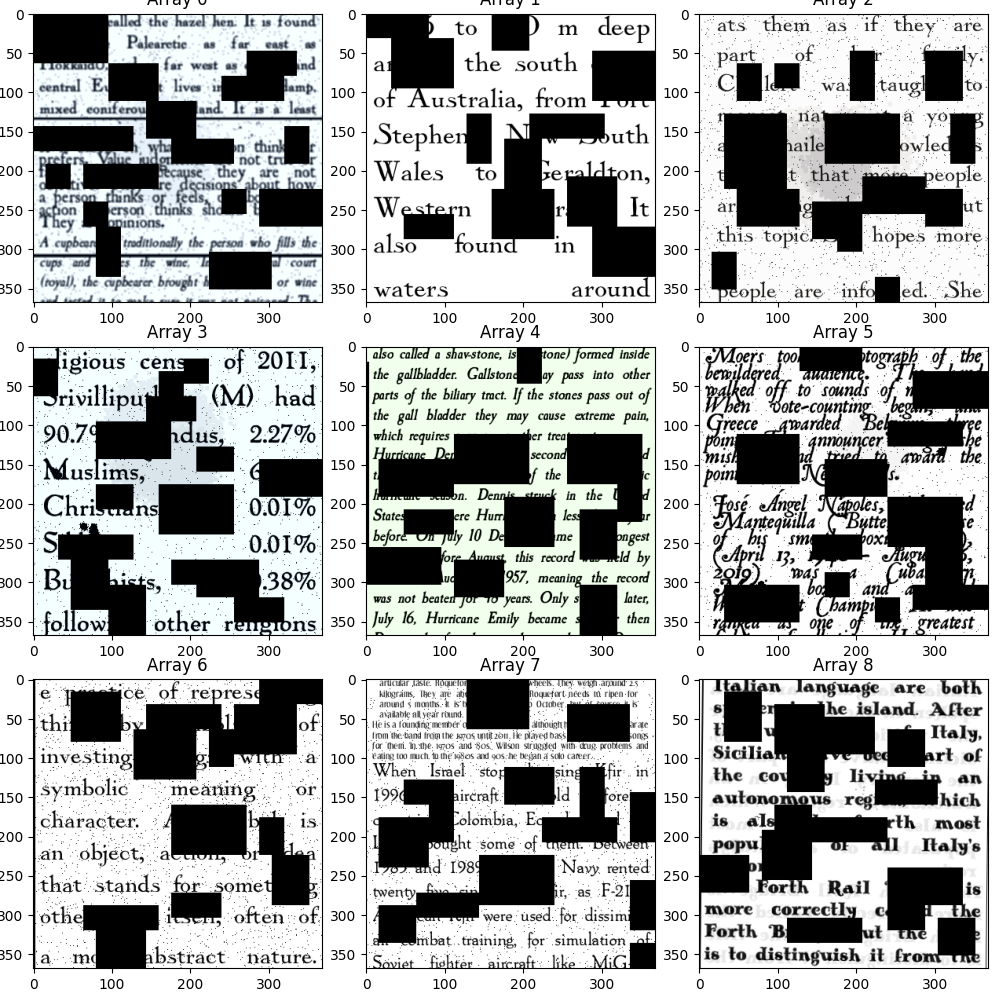

In [15]:
figures = []
for i in range(3):
    train_dataset.set_epoch(i)
    counter = 0
    for batch in train_dataset:
        if counter == 3:
            break
        im = batch["pixel_values"].numpy().astype("uint8").transpose(1, 2, 0)
        mask = batch["patch_mask"].numpy().reshape(23, 23)
        mask = np.kron(mask, np.ones((16, 16))).astype("uint8")
        
        im = im * (1 - mask[..., None])
        figures.append(im)
        counter += 1

im = plot_arrays(figures)
im

In [13]:
mask.min()

0.0